In [ ]:
pip install tslearn

In [ ]:
pip install PyportfoliOopt

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Timestamp
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import warnings
warnings.filterwarnings('ignore')


# 데이터 병합
sectors_data = {}
excel_file_path = 'stocks_2000_2020_data_by_sector-2.xlsx'
snp_price_data = pd.ExcelFile(excel_file_path)
for sheet_name in snp_price_data.sheet_names:
    sheet_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)
    sheet_data['Date'] = pd.to_datetime(sheet_data['Unnamed: 0'])
    sheet_data.set_index('Date', inplace=True)
    sheet_data.drop(columns='Unnamed: 0', inplace=True)
    sectors_data[sheet_name] = sheet_data

# 데이터프레임 생성
df = pd.DataFrame()
for sector, data in sectors_data.items():
    data.columns = [f"{sector}_{col}" for col in data.columns]
    if df.empty:
        df = data
    else:
        df = df.join(data, how='outer')
df

,Tele_VZ,Tele_DIS,Tele_T,Tele_CMCSA,Tele_EA,COND_AMZN,COND_HD,COND_MCD,COND_NKE,COND_SBUX,...,UTIL_NEE,UTIL_DUK,UTIL_D,UTIL_SO,UTIL_EXC,REES_AMT,REES_SPG,REES_CCI,REES_PLD,REES_PSA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,53.903156,29.471687,35.498489,15.583333,25.265625,4.468750,65.187500,39.625000,6.015625,3.082031,...,5.156250,42.057114,19.062500,13.897975,12.080956,29.312500,20.999237,30.531250,19.812500,22.750000
2000-01-04,52.160721,31.198063,33.421452,14.416667,22.343750,4.096875,61.750000,38.812500,5.687500,2.984375,...,5.250000,42.710850,19.531250,14.050700,11.991797,29.000000,20.767200,30.500000,19.500000,22.750000
2000-01-05,53.903156,32.492844,33.940708,14.041667,22.328125,3.487500,63.000000,39.437500,6.015625,3.023438,...,5.421875,44.454151,20.062500,14.776144,12.571327,29.875000,20.941229,30.062500,19.250000,22.937500
2000-01-06,53.284874,31.198063,33.043808,14.583333,20.000000,3.278125,60.000000,38.875000,5.984375,3.132813,...,5.421875,45.652668,20.281250,14.814325,12.593616,29.562500,21.463308,29.000000,19.625000,23.812500
2000-01-07,52.891418,30.704813,33.327038,14.125000,20.593750,3.478125,63.500000,39.875000,5.984375,3.117188,...,5.578125,46.851189,20.281250,15.081594,12.593616,31.187500,22.391451,30.500000,20.000000,24.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,58.959999,173.550003,21.714502,50.040001,141.509995,159.263504,269.809998,212.020004,141.759995,102.059998,...,74.330002,89.040001,74.040001,59.380001,29.750357,217.399994,83.650002,152.460007,96.190002,227.000000
2020-12-24,58.840000,173.729996,21.669184,50.380001,141.809998,158.634506,270.920013,211.389999,141.600006,102.010002,...,74.980003,89.669998,74.230003,59.799999,29.835949,218.649994,84.370003,154.000000,97.239998,228.850006
2020-12-28,58.980000,178.860001,21.563444,51.110001,140.720001,164.197998,269.250000,214.020004,142.429993,104.339996,...,75.489998,90.250000,73.699997,59.990002,30.106991,221.070007,85.480003,156.250000,98.220001,229.139999


In [28]:
# 로그수익률 시계열 생성
return_df = np.log(df / df.shift(1))
return_df

,Tele_VZ,Tele_DIS,Tele_T,Tele_CMCSA,Tele_EA,COND_AMZN,COND_HD,COND_MCD,COND_NKE,COND_SBUX,...,UTIL_NEE,UTIL_DUK,UTIL_D,UTIL_SO,UTIL_EXC,REES_AMT,REES_SPG,REES_CCI,REES_PLD,REES_PSA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.032859,0.056926,-0.060292,-0.077817,-0.122898,-0.086884,-0.054174,-0.020718,-0.056089,-0.032198,...,0.018019,0.015424,0.024293,0.010929,-0.007407,-0.010718,-0.011111,-0.001024,-0.015899,0.000000
2000-01-05,0.032859,0.040664,0.015417,-0.026356,-0.000700,-0.161039,0.020041,0.015975,0.056089,0.013004,...,0.032214,0.040005,0.026837,0.050342,0.047196,0.029726,0.008345,-0.014448,-0.012903,0.008208
2000-01-06,-0.011537,-0.040664,-0.026781,0.037850,-0.110115,-0.061914,-0.048790,-0.014366,-0.005208,0.035537,...,0.000000,0.026604,0.010844,0.002581,0.001771,-0.010515,0.024625,-0.035983,0.019293,0.037438
2000-01-07,-0.007411,-0.015937,0.008535,-0.031933,0.029255,0.059222,0.056695,0.025398,0.000000,-0.005000,...,0.028411,0.025914,0.000000,0.017880,0.000000,0.053511,0.042334,0.050431,0.018928,0.013038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,-0.000509,0.018024,0.012249,0.000400,0.014808,-0.006649,-0.000852,0.000472,-0.004856,-0.003424,...,-0.005099,-0.005488,0.007320,-0.005710,-0.001198,-0.014113,-0.000836,-0.006733,-0.015064,-0.022606
2020-12-24,-0.002037,0.001037,-0.002089,0.006772,0.002118,-0.003957,0.004106,-0.002976,-0.001129,-0.000490,...,0.008707,0.007051,0.002563,0.007048,0.002873,0.005733,0.008570,0.010050,0.010857,0.008117
2020-12-28,0.002377,0.029101,-0.004892,0.014386,-0.007716,0.034470,-0.006183,0.012365,0.005844,0.022584,...,0.006779,0.006447,-0.007166,0.003172,0.009043,0.011007,0.013071,0.014505,0.010028,0.001266


error


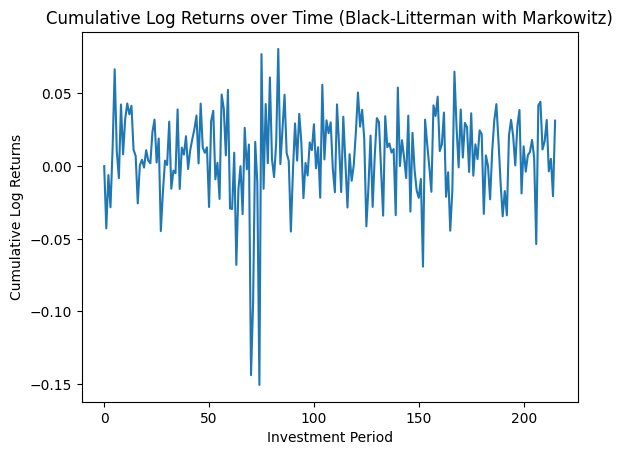

In [29]:
# 날짜 계산
invest_start_day = return_df.index[return_df.index>='2003-01-01'][0]
learn_window = 60
invest_window = 20
invest_end_day = return_df.index[return_df.index.tolist().index(invest_start_day) + invest_window]
learn_start_day = return_df.index[return_df.index.tolist().index(invest_start_day) - learn_window]
learn_end_day = return_df.index[return_df.index.tolist().index(invest_start_day) - 1]
returns_all = [0]
while invest_end_day< Timestamp('2020-12-30'):
    # 학습 데이터 수집
    learn_data = df.loc[learn_start_day:learn_end_day].dropna(axis=1)
    learn_data = learn_data.iloc[:, :100]
    # 포트폴리오 계산
    mu = expected_returns.mean_historical_return(learn_data)
    S = risk_models.sample_cov(learn_data)
    ef = EfficientFrontier(mu, S)
    try:
        ef.min_volatility()
        w = ef.clean_weights()
        w_df = pd.DataFrame([w.values()], columns=w)
        # 수익률 계산
        returns = []
        for i, v in enumerate(w_df):
            returns.append(np.log(df.loc[invest_end_day, v] / df.loc[invest_start_day, v]))
        w_df.loc[1] = returns
        w_df.loc[2] = w_df.loc[0] * w_df.loc[1]
        this_return = w_df.loc[2].sum()
    except:
        print('error')
        this_return = 0
    returns_all.append(this_return)
    # 다음 투자 기간으로 리밸런싱
    next_invest_end_index = return_df.index.tolist().index(invest_end_day) + invest_window + 1 # 다음 투자기간 종료
    next_invest_start_index = return_df.index.tolist().index(invest_start_day) + invest_window + 1 # 다음 투자기간 시작

    # 인덱스가 범위를 벗어나는지 확인
    if next_invest_end_index >= len(return_df.index) or next_invest_start_index >= len(return_df.index):
        break

    # 다음 투자 update
    invest_start_day = return_df.index[next_invest_start_index]
    invest_end_day = return_df.index[next_invest_end_index]
    learn_start_day = return_df.index[next_invest_start_index - learn_window]
    learn_end_day = return_df.index[next_invest_start_index - 1]


plt.plot(returns_all)
plt.xlabel('Investment Period')
plt.ylabel('Cumulative Log Returns')
plt.title('Cumulative Log Returns over Time (Black-Litterman with Markowitz)')
plt.show()

In [30]:
# 월별 로그수익률 계산
monthly_returns = returns_all
monthly_returns

[0,
 -0.04282835338349454,
 -0.006159640705146956,
 -0.02832065944352536,
 0.011976815585915077,
 0.0666136822129681,
 0.010231016872973417,
 -0.008277938990600338,
 0.04239901384747011,
 0.00810793753432865,
 0.03237066054493637,
 0.043091011456094085,
 0.035599604350430206,
 0.04148247966779143,
 0.01120059360457554,
 0.007085404170995237,
 -0.02564680336592158,
 0.0006122268291040786,
 0.004400016818516324,
 -0.0010173219047567585,
 0.010966900552537314,
 0.003873837341209845,
 0.0019463822321830896,
 0.023448306301179583,
 0.032007945252474794,
 0.0024840711236218563,
 0.018991357106142463,
 -0.04472042192468503,
 -0.017691080995834507,
 0.003799211305947077,
 0.0007966197334855001,
 0.030603286190112315,
 -0.015575209573260631,
 -0.003075813525107357,
 -0.004887786326448853,
 0.03904063090607025,
 -0.015701958622791914,
 0.012730058668782736,
 0.007913672692518232,
 0.020601840382276755,
 -0.0019611623437637044,
 0.010788341130162232,
 0.018571921944929015,
 0.02533929406984158,
 

In [31]:
# 연 로그수익률, 표준편차 계산
annual_log_return = np.mean(monthly_returns) * 12 / invest_window * 20
annual_volatility = np.std(monthly_returns) * np.sqrt(12/invest_window*20)

# 1. Sharpe Ratio
risk_free_rate = 0.02
sharpe_ratio = (annual_log_return - risk_free_rate) / annual_volatility

# 2. Sortino Ratio
downside_risks = [r for r in monthly_returns if r < 0]
downside_volatility = np.std(downside_risks) * np.sqrt(12)
sortino_ratio = (annual_log_return - risk_free_rate) / downside_volatility

# 3. Profit Factor
gross_profit = sum([r for r in monthly_returns if r > 0])
gross_loss = abs(sum([r for r in monthly_returns if r < 0]))
profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf  # gross_loss가 0이면 profit_factor는 무한대

# 누적 수익률 계산
cumulative_returns = np.cumsum(monthly_returns)


# monthly_cumulative_returns_df = pd.DataFrame({'Date': df.index[1:len(monthly_returns)+1], 'Cumulative_Log_Return': np.cumsum(monthly_returns)})
# monthly_cumulative_returns_df.to_csv("kshape_cumulative_returns.csv", index=False)

print(len(cumulative_returns))

# MDD 계산
running_max = np.maximum.accumulate(cumulative_returns)
drawdown = cumulative_returns - running_max
mdd = np.min(drawdown)  # MDD는 drawdown의 최소값

# Calmar Ratio 계산
if mdd != 0:
    calmar_ratio = annual_log_return / abs(mdd)
else:
    calmar_ratio = np.mean(cumulative_returns)  # MDD가 0인 경우 평균 누적 수익률로 대체

# 연도별로 cumulative_returns 분할
years = list(range(2003, 2021))
annual_returns = []

for i in range(0, len(years) - 1):  # 마지막 연도는 별도로 처리
    start_index = i * (12 // (invest_window // 20))
    end_index = start_index + (12 // (invest_window // 20))

    # out-of-bounds 오류
    if end_index >= len(cumulative_returns):
        end_index = len(cumulative_returns) - 1

    annual_return = cumulative_returns[end_index] - cumulative_returns[start_index]
    annual_returns.append(annual_return)

# 마지막 연도의 수익률을 별도로 계산
start_index = (years[-1] - 2003) * (12 // (invest_window // 20))
if start_index < len(cumulative_returns):
    annual_return = cumulative_returns[-1] - cumulative_returns[start_index]
    annual_returns.append(annual_return)

# profitable과 unprofitable years 계산
profitable_years = len([r for r in annual_returns if r > 0])
unprofitable_years = len([r for r in annual_returns if r <= 0])

print(f"Profitable Years: {profitable_years}")
print(f"Unprofitable Years: {unprofitable_years}")
print(round(annual_log_return, 3))
print(round(annual_volatility, 3))
print(round(sharpe_ratio, 3))
print(round(sortino_ratio, 3))
print(round(downside_volatility, 3))
print(round(profit_factor, 3))
print(round(gross_profit, 3))
print(round(gross_loss, 3))
print(round(mdd, 3))
print(round(calmar_ratio, 3))


216
Profitable Years: 14
Unprofitable Years: 4
0.084
0.105
0.607
0.677
0.095
1.872
3.245
1.733
-0.51
0.165


In [ ]:
df_monthly_returns = pd.DataFrame(monthly_returns, columns=['0'])
df_monthly_returns.reset_index(inplace=True)
df_monthly_returns.rename(columns={"index": "Unnamed: 0"}, inplace=True)
df_monthly_returns.to_csv("monthly_returns_markowtiz.csv", index=False)